<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/stable_inpainting/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Inpainting 🤗**

In this notebook we will use 🤗 Hugging Face transformers and stable diffusion libraries to explore how to segment and edit photos.


### Refs:
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb#scrollTo=hvdHYdtTu6KA

- https://huggingface.co/blog/mask2former

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.1 M

In [ ]:
import inspect
from typing import List, Optional, Union
import ipywidgets as widgets

import numpy as np
import torch

import PIL
from PIL import Image
import gradio as gr
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from diffusers import StableDiffusionInpaintPipeline

## Obtain Models

In [ ]:
seg_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

### Setup Stable Diffusion inpainting model

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"
# model_path = "stabilityai/stable-diffusion-2-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

safety_checker/model.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Here's some helper functions

In [ ]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

def closest_number(n, m=8):
    """ Obtains closest number to n that is divisble by m """
    return int(n/m) * m

Here's some test image urls

In [71]:
img_url = "https://github.com/itberrios/CV_projects/blob/main/stable_inpainting/assets/Fjord_Cycling.jpg?raw=true"
# img_url = "https://www.oursafetynet.org/wp-content/uploads/2022/12/FB-Promo_Mountains-2.png"
# img_url = "https://learn.corel.com/wp-content/uploads/2022/01/alberta-2297204_1280.jpg"
# img_url = "https://drexel.edu/news/~/media/Drexel/Core-Site-Group/News/Images/v2/story-images/2022/April/nature-relatedness-stock-bcsize/nature-relatedness-stock-bcsize_16x9.ashx"

Download and display image

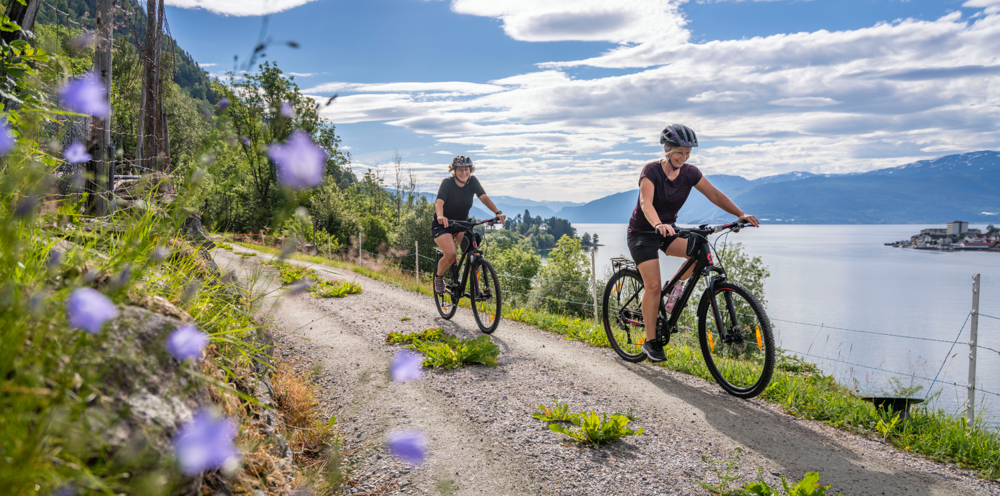

In [72]:
image = download_image(img_url) # .resize((512, 256)) # .resize((1024, 512))

_W, _H = image.size
W, H = closest_number(_W//2), closest_number(_H//2)
image = image.resize((W, H))
image

## Perform Segmentation
**NOTE: You can define your own region to inpaint, in this case we will use
a segmentation model to find an area to remove**

In [73]:
# prep image for segmentation model
inputs = seg_processor(image, return_tensors="pt")

# run segmentation inference
with torch.no_grad():
    seg_outputs = seg_model(**inputs)


# post process segmentation results
seg_prediction = seg_processor.post_process_panoptic_segmentation(seg_outputs, target_sizes=[image.size[::-1]])[0]
print(seg_prediction.keys())

`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


### Display segmentation results

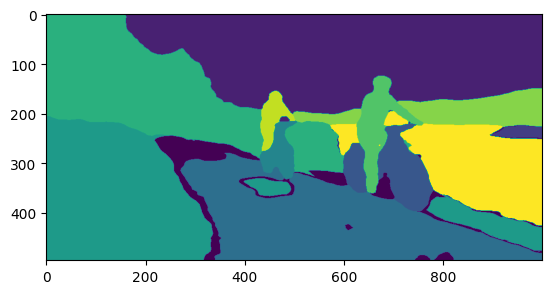

In [74]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(model, segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    # remove legend for better viz
    # ax.legend(handles=handles)

draw_panoptic_segmentation(seg_model, **seg_prediction)

Display Segmentation Labels

In [75]:
segment_labels = {}

for segment in seg_prediction['segments_info']:
    segment_id = segment['id']
    segment_label_id = segment['label_id']
    segment_label = seg_model.config.id2label[segment_label_id]

    segment_labels.update({segment_id : segment_label})

segment_labels

{1: 'sky-other-merged',
 2: 'boat',
 3: 'bicycle',
 4: 'gravel',
 5: 'bicycle',
 6: 'grass-merged',
 7: 'tree-merged',
 8: 'person',
 9: 'mountain-merged',
 10: 'person',
 11: 'sea'}

Manually Select Segmentation mask(s) to inpaint (This can easily be automated)

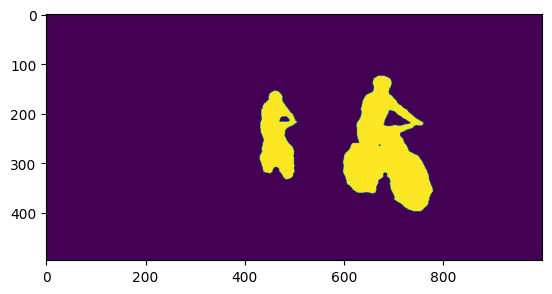

In [76]:
tgts = [3,5,8,10] # change this to get different segmentations
mask = np.array([(seg_prediction['segmentation'] == t).numpy() for t in tgts]).sum(axis=0).astype(np.uint8)*255
plt.imshow(mask);

## **Perform Inpainting with Stable Diffusion Model**

In [77]:
prompt = "inpaint" # set prompt

guidance_scale=17.5
num_samples = 1
generator = torch.Generator(device="cuda").manual_seed(10) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=Image.fromarray(mask), # ensure mask is same type as image
    height=H,
    width=W,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [78]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

# insert mask
images.insert(1, Image.fromarray(mask))

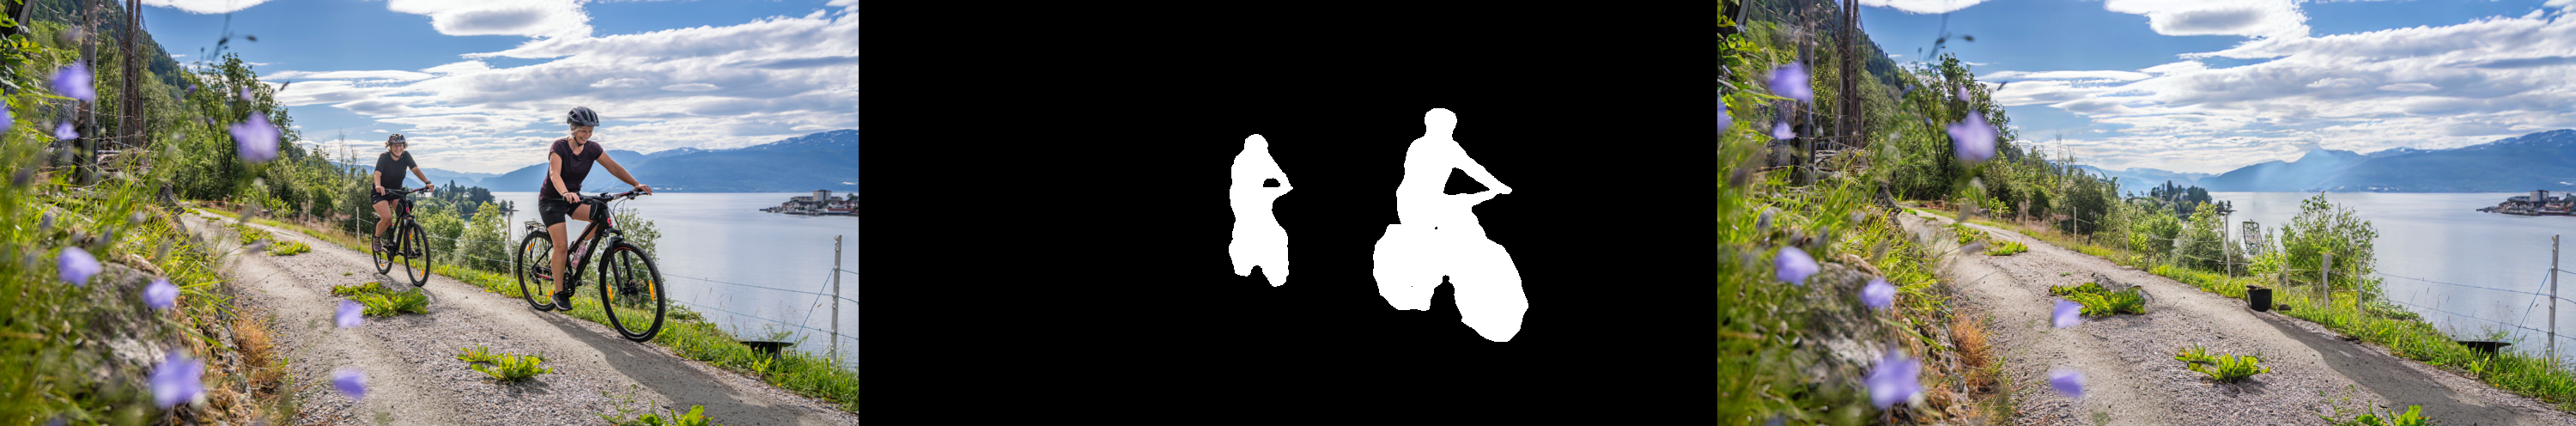

In [79]:
image_grid(images, 1, num_samples + 2)